# PCL Coursework

### Installing Libraries

In [21]:
import sys

!{sys.executable} -m pip install -r ../requirements.txt --break-system-packages

Defaulting to user installation because normal site-packages is not writeable


### Imports

In [22]:
import re, io, ast
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Acquisition, Exploration, and Preprocessing 

### Loading Main Dataset

In [23]:
def load_pcl_tsv(path):
    lines = Path(path).read_text(encoding="utf-8", errors="replace").splitlines()
    start = 0
    for i, line in enumerate(lines):
        if re.match(r"^\d+\t", line):  # first real data row starts with an integer id and tab
            start = i
            break

    data = "\n".join(lines[start:])
    cols = ["par_id","art_id","keyword","country_code","text","label"]
    return pd.read_csv(io.StringIO(data), sep="\t", names=cols, quoting=3)

pcl = load_pcl_tsv("../data/dontpatronizeme_pcl.tsv")
pcl.head()

,par_id,art_id,keyword,country_code,text,label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0


### Shape and Label Distribution

In [24]:
pcl.shape, pcl["label"].value_counts().sort_index()

((10469, 6),
 label
 0    8529
 1     947
 2     144
 3     458
 4     391
 Name: count, dtype: int64)

In [25]:
pcl["bin_label"] = (pcl["label"] >= 2).astype(int)
pcl["bin_label"].value_counts().rename(index={0: "0-1 non-PCL", 1: "2-4 PCL"})

bin_label
0-1 non-PCL    9476
2-4 PCL         993
Name: count, dtype: int64

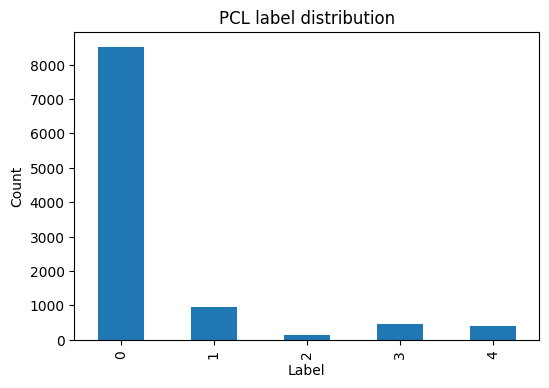

In [26]:
label_counts = pcl["label"].value_counts().sort_index()

plt.figure(figsize=(6,4))
label_counts.plot(kind="bar")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("PCL label distribution")
plt.show()

### Text Length

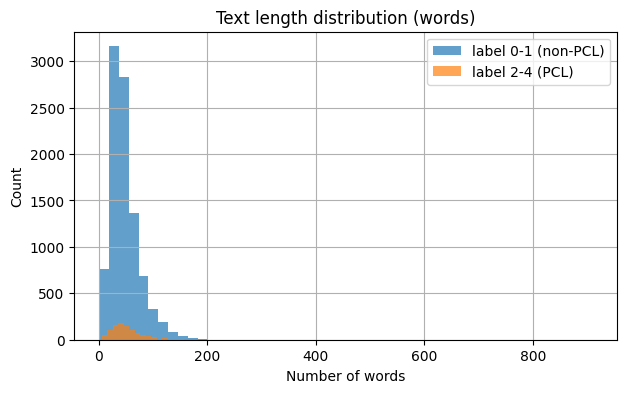

,n_words,n_chars
count,10469.000000,10469.000000
mean,48.422581,267.583150
std,29.091174,160.209018
min,1.000000,3.000000
25%,30.000000,169.000000
50%,42.000000,233.000000
75%,60.000000,330.000000
max,909.000000,5501.000000


In [27]:
pcl["n_chars"] = pcl["text"].astype(str).str.len()
pcl["n_words"] = pcl["text"].astype(str).str.split().apply(len)

plt.figure(figsize=(7,4))
pcl.loc[pcl.label < 2, "n_words"].hist(bins=50, alpha=0.7, label="label 0-1 (non-PCL)")
pcl.loc[pcl.label >= 2, "n_words"].hist(bins=50, alpha=0.7, label="label 2-4 (PCL)")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.title("Text length distribution (words)")
plt.legend()
plt.show()

pcl[["n_words","n_chars"]].describe()

### Lexical Signal

### Discriminative Unigrams

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd

texts = pcl["text"].astype(str).to_list()
y = pcl["bin_label"].astype(int).to_numpy()

cv = CountVectorizer(max_features=12000, stop_words="english", lowercase=True, min_df=5)
X = cv.fit_transform(texts)
vocab = np.array(cv.get_feature_names_out())

pos = np.asarray(X[y == 1].sum(axis=0)).ravel()
neg = np.asarray(X[y == 0].sum(axis=0)).ravel()

pos_total = pos.sum()
neg_total = neg.sum()

# rate ratio with smoothing
rate_ratio = ((pos + 1) / (pos_total + 1)) / ((neg + 1) / (neg_total + 1))

# avoid tiny counts
mask = (pos + neg) >= 40
idx = np.argsort(rate_ratio[mask])[-15:][::-1]

top_tokens = pd.DataFrame({
    "token": vocab[mask][idx],
    "pcl_count": pos[mask][idx].astype(int),
    "nonpcl_count": neg[mask][idx].astype(int),
    "rate_ratio (PCL vs nonPCL)": np.round(rate_ratio[mask][idx], 2),
})
top_tokens

,token,pcl_count,nonpcl_count,rate_ratio (PCL vs nonPCL)
0,christmas,29,16,15.93
1,god,36,31,10.44
2,feed,19,21,8.21
3,plight,21,26,7.36
4,hope,65,106,5.57
5,hunger,15,25,5.56
6,helping,34,64,4.86
7,streets,32,61,4.81
8,charity,26,54,4.43
9,kids,26,54,4.43


### Discriminative Bigrams

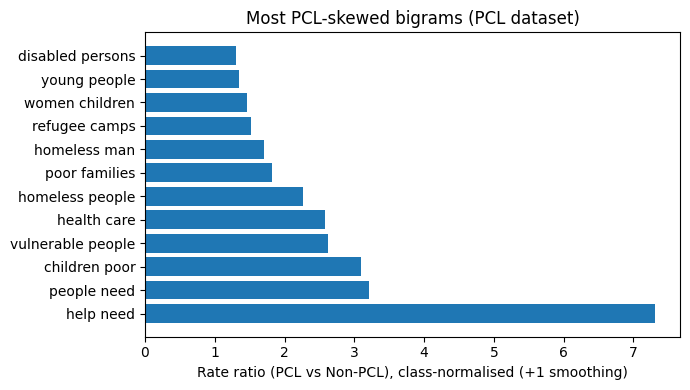

In [29]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

cv2 = CountVectorizer(
    max_features=20000,
    stop_words="english",
    lowercase=True,
    ngram_range=(2, 2),
    min_df=5
)

X2 = cv2.fit_transform(texts)
vocab2 = np.array(cv2.get_feature_names_out())

pos2 = np.asarray(X2[y == 1].sum(axis=0)).ravel()
neg2 = np.asarray(X2[y == 0].sum(axis=0)).ravel()

pos2_total = pos2.sum()
neg2_total = neg2.sum()

mask2 = (pos2 + neg2) >= 40
rate_ratio2 = ((pos2 + 1) / (pos2_total + 1)) / ((neg2 + 1) / (neg2_total + 1))

topk = 12
idx2 = np.argsort(rate_ratio2[mask2])[-topk:][::-1]
bigrams = vocab2[mask2][idx2]
vals = rate_ratio2[mask2][idx2]

plt.figure(figsize=(7, 4))
plt.barh(range(len(bigrams))[::-1], vals[::-1])
plt.yticks(range(len(bigrams))[::-1], bigrams[::-1])
plt.xlabel("Rate ratio (PCL vs Non-PCL), class-normalised (+1 smoothing)")
plt.title("Most PCL-skewed bigrams (PCL dataset)")
plt.tight_layout()
plt.show()

### Load training and dev data

In [30]:
train_data = pd.read_csv("../data/train_data.csv")
dev_data = pd.read_csv("../data/dev_data.csv")

train_data.head(), dev_data.head(), train_data.shape, dev_data.shape

(   par_id                  label
 0    4341  [1, 0, 0, 1, 0, 0, 0]
 1    4136  [0, 1, 0, 0, 0, 0, 0]
 2   10352  [1, 0, 0, 0, 0, 1, 0]
 3    8279  [0, 0, 0, 1, 0, 0, 0]
 4    1164  [1, 0, 0, 1, 1, 1, 0],
    par_id                  label
 0    4046  [1, 0, 0, 1, 0, 0, 0]
 1    1279  [0, 1, 0, 0, 0, 0, 0]
 2    8330  [0, 0, 1, 0, 0, 0, 0]
 3    4063  [1, 0, 0, 1, 1, 1, 0]
 4    4089  [1, 0, 0, 0, 0, 0, 0],
 (8375, 2),
 (2094, 2))

### Parse Multi-label Vectors

In [31]:
def parse_labels(label_str):
    s = str(label_str).strip()
    try:
        v = ast.literal_eval(s)
        if isinstance(v, list):
            return v
    except Exception:
        pass
    parts = re.split(r"[,\s]+", s.strip("[]()"))
    parts = [p for p in parts if p != ""]
    return [int(p) for p in parts if p.isdigit()]

train_data["y_bin"] = train_data["label"].apply(parse_labels)
dev_data["y_bin"] = dev_data["label"].apply(parse_labels)

train_data["y_bin"].iloc[0], train_data["y_bin"].apply(len).value_counts()

([1, 0, 0, 1, 0, 0, 0],
 y_bin
 7    8375
 Name: count, dtype: int64)

### Merge labels with main text

In [32]:
train = train_data.merge(
    pcl[["par_id", "text", "label", "keyword", "country_code"]],
    on="par_id",
    how="left",
    suffixes=("_ml", "_pcl")
)

dev = dev_data.merge(
    pcl[["par_id", "text", "label", "keyword", "country_code"]],
    on="par_id",
    how="left",
    suffixes=("_ml", "_pcl")
)

train[["par_id", "label_pcl", "text"]].head()

,par_id,label_pcl,text
0,4341,4,"The scheme saw an estimated 150,000 children f..."
1,4136,2,Durban 's homeless communities reconciliation ...
2,10352,4,The next immediate problem that cropped up was...
3,8279,2,Far more important than the implications for t...
4,1164,4,To strengthen child-sensitive social protectio...


### Expanding using category names

In [33]:
categories = [
    "Unbalanced power relations",
    "Compassion",
    "Presupposition",
    "Authority voice",
    "Shallow solution",
    "Metaphor",
    "The poorer, the merrier",
]

cat_cols = [f"cat_{i}" for i in range(7)]
train[cat_cols] = pd.DataFrame(train["y_bin"].tolist(), index=train.index)
dev[cat_cols] = pd.DataFrame(dev["y_bin"].tolist(), index=dev.index)

train[cat_cols].head()

,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6
0,1,0,0,1,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0
4,1,0,0,1,1,1,0


### Category counts

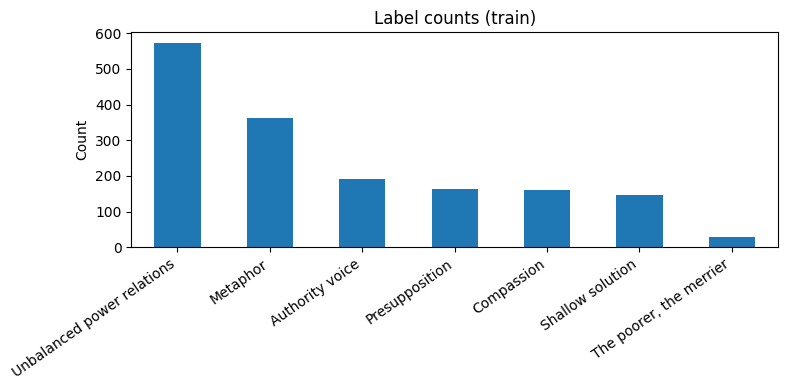

In [34]:
cat_counts = train[cat_cols].sum().astype(int)
cat_counts.index = categories
cat_counts.sort_values(ascending=False)

plt.figure(figsize=(8,4))
cat_counts.sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Count")
plt.title("Label counts (train)")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()

### Categories per Example

In [35]:
train["n_cats"] = train[cat_cols].sum(axis=1)
train["n_cats"].value_counts().sort_index()

n_cats
0    7581
1     243
2     335
3     159
4      50
5       7
Name: count, dtype: int64

### Load Test Dataset

In [36]:
def load_test_data(path):
    lines = Path(path).read_text(encoding="utf-8", errors="replace").splitlines()
    data = "\n".join(lines)
    cols = ["par_id","art_id","keyword","country_code","text"]
    return pd.read_csv(io.StringIO(data), sep="\t", names=cols, quoting=3)

test = load_test_data("../data/test_data.tsv")
test.head(), test.shape

(  par_id      art_id     keyword country_code  \
 0    t_0   @@7258997  vulnerable           us   
 1    t_1  @@16397324       women           pk   
 2    t_2  @@16257812     migrant           ca   
 3    t_3   @@3509652     migrant           gb   
 4    t_4    @@477506  vulnerable           ca   
 
                                                 text  
 0  In the meantime , conservatives are working to...  
 1  In most poor households with no education chil...  
 2  The real question is not whether immigration i...  
 3  In total , the country 's immigrant population...  
 4  Members of the church , which is part of Ken C...  ,
 (3832, 5))

## Stage 4: Implementation and tuning

All model code for this stage is kept in this notebook: training pipeline, threshold tuning, hyperparameter sweep, and final inference outputs.


In [37]:
import ast
import csv
import itertools
import random
from dataclasses import dataclass, replace
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
!{sys.executable} -m pip install transformers sentencepiece protobuf --break-system-packages
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup

NUM_TAXONOMY_LABELS = 7


@dataclass
class TrainingConfig:
    main_tsv_path: Path
    train_taxonomy_path: Path
    dev_taxonomy_path: Path
    test_tsv_path: Path
    output_dir: Path = Path("artefacts")
    checkpoint_name: str = "best_multitask_model.pt"
    submission_path: Path = Path("submissions/test_predictions.csv")
    dev_submission_path: Path = Path("dev.txt")
    test_submission_path: Path = Path("test.txt")
    primary_model_name: str = "microsoft/deberta-v3-base"
    fallback_model_name: str = "roberta-base"
    batch_size: int = 16
    max_length: int = 256
    num_epochs: int = 5
    learning_rate: float = 2e-5
    weight_decay: float = 0.01
    warmup_ratio: float = 0.1
    gradient_clip_norm: float = 1.0
    lambda_tax: float = 0.5
    early_stopping_patience: int = 2
    mixed_precision: bool = True
    random_seed: int = 42
    num_workers: int = 0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    @property
    def checkpoint_path(self) -> Path:
        return self.output_dir / self.checkpoint_name


Defaulting to user installation because normal site-packages is not writeable


In [38]:
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def parse_tax_labels(label_text: str) -> np.ndarray:
    if isinstance(label_text, str):
        label_text = label_text.strip()

    try:
        parsed = ast.literal_eval(label_text)
    except (SyntaxError, ValueError, TypeError):
        cleaned = str(label_text).strip().strip("[]")
        parsed = [part.strip() for part in cleaned.split(",") if part.strip()]

    if not isinstance(parsed, (list, tuple)):
        raise ValueError(f"Could not parse taxonomy labels: {label_text}")

    values = np.asarray(parsed, dtype=np.float32)
    if values.shape[0] != NUM_TAXONOMY_LABELS:
        raise ValueError(
            f"Expected {NUM_TAXONOMY_LABELS} taxonomy values, found {values.shape[0]} in {label_text}"
        )
    return values


def load_main_pcl(path: Path) -> pd.DataFrame:
    rows = []
    with path.open("r", encoding="utf-8") as handle:
        reader = csv.reader(handle, delimiter="	")
        for parts in reader:
            if len(parts) < 6:
                continue
            if not parts[0].strip().isdigit():
                continue

            try:
                label_value = int(float(parts[-1].strip()))
            except ValueError:
                continue

            rows.append(
                {
                    "par_id": int(parts[0].strip()),
                    "article_id": parts[1].strip(),
                    "keyword": parts[2].strip(),
                    "country_code": parts[3].strip(),
                    "text": "	".join(parts[4:-1]).strip(),
                    "label": label_value,
                }
            )

    if not rows:
        raise ValueError(f"No valid rows were read from {path}")
    return pd.DataFrame(rows)


def load_taxonomy_split(path: Path) -> pd.DataFrame:
    split_rows = pd.read_csv(path, dtype={"par_id": str, "label": str})
    expected = {"par_id", "label"}
    if not expected.issubset(set(split_rows.columns)):
        raise ValueError(f"Expected columns {expected} in {path}, found {split_rows.columns.tolist()}")

    split_rows["par_id"] = pd.to_numeric(split_rows["par_id"], errors="raise").astype(int)
    split_rows["y_tax"] = split_rows["label"].apply(parse_tax_labels)
    return split_rows.rename(columns={"label": "taxonomy_label_raw"})


def merge_split_text(split_rows: pd.DataFrame, main_rows: pd.DataFrame) -> pd.DataFrame:
    merged = split_rows.merge(
        main_rows[["par_id", "text", "label"]],
        on="par_id",
        how="left",
        validate="one_to_one",
    )

    missing_text_count = int(merged["text"].isna().sum())
    if missing_text_count:
        raise ValueError(f"{missing_text_count} rows have no matching text in main TSV.")

    merged["text"] = merged["text"].fillna("").astype(str)
    merged["y_bin"] = (merged["label"] >= 2).astype(np.float32)
    return merged[["par_id", "text", "y_bin", "y_tax"]].copy()


def load_train_and_dev_data(main_tsv_path: Path, train_taxonomy_path: Path, dev_taxonomy_path: Path):
    main_rows = load_main_pcl(main_tsv_path)
    train_split_rows = load_taxonomy_split(train_taxonomy_path)
    dev_split_rows = load_taxonomy_split(dev_taxonomy_path)

    train_rows = merge_split_text(train_split_rows, main_rows)
    dev_rows = merge_split_text(dev_split_rows, main_rows)
    return train_rows, dev_rows


def load_test_data(path: Path) -> pd.DataFrame:
    rows = []
    with path.open("r", encoding="utf-8") as handle:
        reader = csv.reader(handle, delimiter="	")
        for parts in reader:
            if len(parts) < 5:
                continue

            par_id = parts[0].strip()
            if not par_id or par_id.lower() == "par_id":
                continue

            rows.append(
                {
                    "par_id": par_id,
                    "text": "	".join(parts[4:]).strip(),
                }
            )

    if not rows:
        raise ValueError(f"No valid rows were read from {path}")
    return pd.DataFrame(rows)[["par_id", "text"]].copy()


class PCLDataset(Dataset):
    def __init__(self, input_ids, attention_mask, bin_targets=None, tax_targets=None):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.bin_targets = bin_targets
        self.tax_targets = tax_targets

    def __len__(self):
        return self.input_ids.shape[0]

    def __getitem__(self, index):
        item = {
            "input_ids": self.input_ids[index],
            "attention_mask": self.attention_mask[index],
        }
        if self.bin_targets is not None and self.tax_targets is not None:
            item["y_bin"] = self.bin_targets[index]
            item["y_tax"] = self.tax_targets[index]
        return item


def build_dataset(rows: pd.DataFrame, tokeniser, max_length: int, include_labels: bool = True):
    encoded = tokeniser(
        rows["text"].fillna("").astype(str).tolist(),
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt",
    )

    if include_labels:
        bin_targets = torch.tensor(rows["y_bin"].to_numpy(dtype=np.float32), dtype=torch.float32)
        tax_targets = torch.tensor(np.stack(rows["y_tax"].values), dtype=torch.float32)
    else:
        bin_targets = None
        tax_targets = None

    return PCLDataset(
        input_ids=encoded["input_ids"],
        attention_mask=encoded["attention_mask"],
        bin_targets=bin_targets,
        tax_targets=tax_targets,
    )


def build_dataloader(
    rows: pd.DataFrame,
    tokeniser,
    batch_size: int,
    max_length: int,
    shuffle: bool,
    num_workers: int = 0,
    include_labels: bool = True,
):
    dataset = build_dataset(rows, tokeniser, max_length, include_labels)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
    )


def compute_bin_pos_weight(bin_targets: np.ndarray) -> torch.Tensor:
    positives = float((bin_targets == 1).sum())
    negatives = float((bin_targets == 0).sum())
    if positives == 0:
        return torch.tensor(1.0, dtype=torch.float32)
    return torch.tensor(negatives / positives, dtype=torch.float32)


def binary_metrics(probabilities: np.ndarray, targets: np.ndarray, threshold: float):
    predictions = (probabilities >= threshold).astype(np.int64)
    targets_int = targets.astype(np.int64)

    tp = int(((predictions == 1) & (targets_int == 1)).sum())
    tn = int(((predictions == 0) & (targets_int == 0)).sum())
    fp = int(((predictions == 1) & (targets_int == 0)).sum())
    fn = int(((predictions == 0) & (targets_int == 1)).sum())

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        "threshold": float(threshold),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "confusion_matrix": {"tn": tn, "fp": fp, "fn": fn, "tp": tp},
    }


In [39]:
class MultiHeadPCLModel(nn.Module):
    def __init__(self, encoder_name: str):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(encoder_name)
        hidden_size = self.encoder.config.hidden_size
        self.binary_head = nn.Linear(hidden_size, 1)
        self.taxonomy_head = nn.Linear(hidden_size, 7)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True,
        )
        pooled = outputs.last_hidden_state[:, 0, :]
        pooled_bin = pooled.to(self.binary_head.weight.dtype)
        pooled_tax = pooled.to(self.taxonomy_head.weight.dtype)
        logit_bin = self.binary_head(pooled_bin).squeeze(-1)
        logits_tax = self.taxonomy_head(pooled_tax)
        return logit_bin, logits_tax


def load_tokeniser_and_model(primary_model_name: str, fallback_model_name: str):
    errors = {}
    for model_name in [primary_model_name, fallback_model_name]:
        try:
            tokeniser = AutoTokenizer.from_pretrained(model_name)
            model = MultiHeadPCLModel(model_name)
            return model_name, tokeniser, model
        except Exception as exc:
            errors[model_name] = str(exc)

    details = " | ".join(f"{name}: {message}" for name, message in errors.items())
    raise RuntimeError(f"Could not load either primary or fallback model. Details: {details}")


def eval_on_dev(model, dev_loader, device, binary_loss_fn, taxonomy_loss_fn, lambda_tax: float):
    model.eval()
    running_loss = 0.0
    probabilities = []
    targets = []

    with torch.no_grad():
        for batch in dev_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            y_bin = batch["y_bin"].to(device)
            y_tax = batch["y_tax"].to(device)

            logit_bin, logits_tax = model(input_ids=input_ids, attention_mask=attention_mask)
            loss_bin = binary_loss_fn(logit_bin, y_bin)
            loss_tax = taxonomy_loss_fn(logits_tax, y_tax)
            loss = loss_bin + lambda_tax * loss_tax

            running_loss += float(loss.item())
            probabilities.append(torch.sigmoid(logit_bin).detach().cpu().numpy())
            targets.append(y_bin.detach().cpu().numpy())

    prob_array = np.concatenate(probabilities)
    target_array = np.concatenate(targets)
    metrics = binary_metrics(prob_array, target_array, threshold=0.5)
    avg_loss = running_loss / max(1, len(dev_loader))

    return {
        "loss": avg_loss,
        "probabilities": prob_array,
        "targets": target_array,
        "metrics_at_0_5": metrics,
    }


def train_model(
    model,
    train_loader,
    dev_loader,
    config: TrainingConfig,
    pos_weight: torch.Tensor,
    checkpoint_path: Path,
    model_name: str,
    persist_checkpoint: bool = True,
):
    device = torch.device(config.device)
    model.to(device)

    if any(param.dtype != torch.float32 for param in model.parameters()):
        print("Normalising model parameters to FP32 before training.")
        model = model.float().to(device)

    binary_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
    taxonomy_loss_fn = nn.BCEWithLogitsLoss()
    optimiser = AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    total_steps = max(1, config.num_epochs * len(train_loader))
    warmup_steps = int(config.warmup_ratio * total_steps)
    scheduler = get_linear_schedule_with_warmup(
        optimiser,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    amp_enabled = config.mixed_precision and device.type == "cuda"
    scaler = GradScaler(enabled=amp_enabled)

    best_dev_f1 = -1.0
    best_epoch = 0
    stale_epochs = 0
    history = []
    best_state_dict = None
    checkpoint_write_failed = False

    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)

    for epoch in range(1, config.num_epochs + 1):
        model.train()
        running_train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{config.num_epochs}", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            y_bin = batch["y_bin"].to(device)
            y_tax = batch["y_tax"].to(device)

            optimiser.zero_grad(set_to_none=True)
            with autocast(enabled=amp_enabled):
                logit_bin, logits_tax = model(input_ids=input_ids, attention_mask=attention_mask)
                loss_bin = binary_loss_fn(logit_bin, y_bin)
                loss_tax = taxonomy_loss_fn(logits_tax, y_tax)
                loss = loss_bin + config.lambda_tax * loss_tax

            if amp_enabled:
                try:
                    scaler.scale(loss).backward()
                    scaler.unscale_(optimiser)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip_norm)
                    scaler.step(optimiser)
                    scaler.update()
                except ValueError as exc:
                    if "Attempting to unscale FP16 gradients" in str(exc):
                        print("Switching off mixed precision due to FP16 gradient unscale issue.")
                        amp_enabled = False
                        scaler = GradScaler(enabled=False)
                        optimiser.zero_grad(set_to_none=True)
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip_norm)
                        optimiser.step()
                    else:
                        raise
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip_norm)
                optimiser.step()
            scheduler.step()

            running_train_loss += float(loss.item())

        avg_train_loss = running_train_loss / max(1, len(train_loader))
        dev_eval = eval_on_dev(model, dev_loader, device, binary_loss_fn, taxonomy_loss_fn, config.lambda_tax)

        dev_metrics = dev_eval["metrics_at_0_5"]
        history.append(
            {
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "dev_loss": dev_eval["loss"],
                "dev_precision_at_0_5": dev_metrics["precision"],
                "dev_recall_at_0_5": dev_metrics["recall"],
                "dev_f1_at_0_5": dev_metrics["f1"],
            }
        )

        print(
            f"Epoch {epoch:02d} | train_loss={avg_train_loss:.4f} | "
            f"dev_loss={dev_eval['loss']:.4f} | dev_f1@0.5={dev_metrics['f1']:.4f}"
        )

        if dev_metrics["f1"] > best_dev_f1:
            best_dev_f1 = dev_metrics["f1"]
            best_epoch = epoch
            stale_epochs = 0
            best_state_dict = {
                name: tensor.detach().cpu().clone()
                for name, tensor in model.state_dict().items()
            }

            if persist_checkpoint:
                try:
                    torch.save(
                        {
                            "model_state_dict": best_state_dict,
                            "model_name": model_name,
                            "best_dev_f1": best_dev_f1,
                            "best_epoch": best_epoch,
                        },
                        checkpoint_path,
                    )
                except RuntimeError as exc:
                    if not checkpoint_write_failed:
                        print(f"Checkpoint write failed, continuing without disk checkpoints: {exc}")
                        checkpoint_write_failed = True
                    persist_checkpoint = False
        else:
            stale_epochs += 1
            if stale_epochs >= config.early_stopping_patience:
                print(f"Early stopping at epoch {epoch:02d}.")
                break

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model.to(device)

    return {
        "history": history,
        "best_dev_f1_at_0_5": best_dev_f1,
        "best_epoch": best_epoch,
        "checkpoint_path": str(checkpoint_path) if persist_checkpoint else None,
    }


def tune_threshold(
    probabilities: np.ndarray,
    targets: np.ndarray,
    start: float = 0.05,
    end: float = 0.95,
    step: float = 0.01,
):
    thresholds = np.round(np.arange(start, end + 1e-9, step), 2)
    metrics_at_0_5 = binary_metrics(probabilities, targets, threshold=0.5)

    best_threshold = 0.5
    best_metrics = metrics_at_0_5

    for threshold in thresholds:
        metrics = binary_metrics(probabilities, targets, threshold=float(threshold))
        if metrics["f1"] > best_metrics["f1"]:
            best_threshold = float(threshold)
            best_metrics = metrics

    return {
        "best_threshold": best_threshold,
        "metrics_at_0_5": metrics_at_0_5,
        "metrics_at_best_threshold": best_metrics,
    }


def predict_binary_probabilities(model, data_loader, device: torch.device, return_targets: bool = False):
    model.eval()
    probabilities = []
    targets = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            logit_bin, _ = model(input_ids=input_ids, attention_mask=attention_mask)

            probabilities.append(torch.sigmoid(logit_bin).detach().cpu().numpy())
            if return_targets and "y_bin" in batch:
                targets.append(batch["y_bin"].detach().cpu().numpy())

    prob_array = np.concatenate(probabilities)
    target_array = np.concatenate(targets) if targets else None
    return prob_array, target_array


def write_prediction_lines(predictions: np.ndarray, output_path: Path):
    output_path.parent.mkdir(parents=True, exist_ok=True)
    with output_path.open("w", encoding="utf-8") as handle:
        for value in predictions.astype(int).tolist():
            handle.write(f"{int(value)}\n")
    return output_path


def write_test_predictions_csv(par_ids, predictions: np.ndarray, output_path: Path):
    output_rows = pd.DataFrame({"par_id": par_ids, "label": predictions.astype(int)})
    output_path.parent.mkdir(parents=True, exist_ok=True)
    output_rows.to_csv(output_path, index=False)
    return output_path


def run_training_and_inference(
    config: TrainingConfig,
    write_submission: bool = True,
    train_rows_override: pd.DataFrame | None = None,
    dev_rows_override: pd.DataFrame | None = None,
    persist_checkpoint: bool | None = None,
):
    set_seed(config.random_seed)
    device = torch.device(config.device)

    if persist_checkpoint is None:
        persist_checkpoint = bool(write_submission)

    if train_rows_override is not None and dev_rows_override is not None:
        train_rows = train_rows_override.reset_index(drop=True).copy()
        dev_rows = dev_rows_override.reset_index(drop=True).copy()
    else:
        train_rows, dev_rows = load_train_and_dev_data(
            main_tsv_path=Path(config.main_tsv_path),
            train_taxonomy_path=Path(config.train_taxonomy_path),
            dev_taxonomy_path=Path(config.dev_taxonomy_path),
        )

    loaded_model_name, tokeniser, model = load_tokeniser_and_model(
        primary_model_name=config.primary_model_name,
        fallback_model_name=config.fallback_model_name,
    )

    train_loader = build_dataloader(
        rows=train_rows,
        tokeniser=tokeniser,
        batch_size=config.batch_size,
        max_length=config.max_length,
        shuffle=True,
        num_workers=config.num_workers,
        include_labels=True,
    )
    dev_loader = build_dataloader(
        rows=dev_rows,
        tokeniser=tokeniser,
        batch_size=config.batch_size,
        max_length=config.max_length,
        shuffle=False,
        num_workers=config.num_workers,
        include_labels=True,
    )

    pos_weight = compute_bin_pos_weight(train_rows["y_bin"].to_numpy(dtype=np.float32))
    training_summary = train_model(
        model=model,
        train_loader=train_loader,
        dev_loader=dev_loader,
        config=config,
        pos_weight=pos_weight,
        checkpoint_path=Path(config.checkpoint_path),
        model_name=loaded_model_name,
        persist_checkpoint=persist_checkpoint,
    )

    dev_probabilities, dev_targets = predict_binary_probabilities(
        model=model,
        data_loader=dev_loader,
        device=device,
        return_targets=True,
    )
    if dev_targets is None:
        raise RuntimeError("Dev targets were not returned. This should not happen.")

    threshold_summary = tune_threshold(
        probabilities=dev_probabilities,
        targets=dev_targets,
        start=0.05,
        end=0.95,
        step=0.01,
    )

    tuned_threshold = float(threshold_summary["best_threshold"])

    test_size = 0
    dev_submission_path = None
    test_submission_path = None
    submission_path = None

    if write_submission:
        dev_predictions = (dev_probabilities >= tuned_threshold).astype(int)
        dev_output_path = write_prediction_lines(
            predictions=dev_predictions,
            output_path=Path(config.dev_submission_path),
        )
        dev_submission_path = str(dev_output_path)

        test_rows = load_test_data(Path(config.test_tsv_path))
        test_loader = build_dataloader(
            rows=test_rows,
            tokeniser=tokeniser,
            batch_size=config.batch_size,
            max_length=config.max_length,
            shuffle=False,
            num_workers=config.num_workers,
            include_labels=False,
        )
        test_probabilities, _ = predict_binary_probabilities(
            model=model,
            data_loader=test_loader,
            device=device,
            return_targets=False,
        )
        test_predictions = (test_probabilities >= tuned_threshold).astype(int)

        test_output_path = write_prediction_lines(
            predictions=test_predictions,
            output_path=Path(config.test_submission_path),
        )
        test_submission_path = str(test_output_path)

        output_path = write_test_predictions_csv(
            par_ids=test_rows["par_id"].tolist(),
            predictions=test_predictions,
            output_path=Path(config.submission_path),
        )

        test_size = int(len(test_rows))
        submission_path = str(output_path)

    return {
        "loaded_model_name": loaded_model_name,
        "device": str(device),
        "train_size": int(len(train_rows)),
        "dev_size": int(len(dev_rows)),
        "test_size": test_size,
        "training_summary": training_summary,
        "threshold_summary": threshold_summary,
        "dev_submission_path": dev_submission_path,
        "test_submission_path": test_submission_path,
        "submission_path": submission_path,
    }


def iter_sweep_settings(sweep_space: dict):
    keys = list(sweep_space.keys())
    value_lists = [sweep_space[key] for key in keys]
    for combo in itertools.product(*value_lists):
        yield dict(zip(keys, combo))


def create_internal_split(
    train_rows: pd.DataFrame,
    dev_ratio: float = 0.15,
    random_seed: int = 42,
):
    if not 0.0 < dev_ratio < 1.0:
        raise ValueError(f"dev_ratio must be between 0 and 1, got {dev_ratio}")

    indices = np.arange(len(train_rows))
    train_indices, dev_indices = train_test_split(
        indices,
        test_size=dev_ratio,
        random_state=random_seed,
        stratify=train_rows["y_bin"].to_numpy(),
        shuffle=True,
    )

    internal_train_rows = train_rows.iloc[train_indices].reset_index(drop=True)
    internal_dev_rows = train_rows.iloc[dev_indices].reset_index(drop=True)
    return internal_train_rows, internal_dev_rows


def run_hyperparameter_sweep(
    base_config: TrainingConfig,
    sweep_space: dict,
    sweep_dir: Path,
    max_trials: int | None = None,
    internal_dev_ratio: float = 0.15,
):
    full_train_rows, _ = load_train_and_dev_data(
        main_tsv_path=Path(base_config.main_tsv_path),
        train_taxonomy_path=Path(base_config.train_taxonomy_path),
        dev_taxonomy_path=Path(base_config.dev_taxonomy_path),
    )
    sweep_train_rows, sweep_dev_rows = create_internal_split(
        train_rows=full_train_rows,
        dev_ratio=internal_dev_ratio,
        random_seed=base_config.random_seed,
    )

    all_trials = list(iter_sweep_settings(sweep_space))
    rng = random.Random(base_config.random_seed)
    rng.shuffle(all_trials)

    if max_trials is not None:
        all_trials = all_trials[:max_trials]

    if not all_trials:
        raise ValueError("No hyperparameter trials were created. Check sweep_space.")

    sweep_dir.mkdir(parents=True, exist_ok=True)
    trial_rows = []
    best_params = None
    best_score = -1.0

    total_trials = len(all_trials)
    print(f"Running {total_trials} sweep trials")

    for trial_index, trial_params in enumerate(all_trials, start=1):
        trial_name = f"trial_{trial_index:03d}"
        trial_output_dir = sweep_dir / trial_name

        trial_config = replace(base_config, output_dir=trial_output_dir, **trial_params)

        print(f"\nTrial {trial_index}/{total_trials}: {trial_params}")
        trial_results = run_training_and_inference(
            trial_config,
            write_submission=False,
            train_rows_override=sweep_train_rows,
            dev_rows_override=sweep_dev_rows,
        )

        tuned_metrics = trial_results["threshold_summary"]["metrics_at_best_threshold"]
        metrics_at_0_5 = trial_results["threshold_summary"]["metrics_at_0_5"]
        tuned_f1 = float(tuned_metrics["f1"])

        row = {
            "trial": trial_name,
            **trial_params,
            "dev_f1_tuned": tuned_f1,
            "dev_precision_tuned": float(tuned_metrics["precision"]),
            "dev_recall_tuned": float(tuned_metrics["recall"]),
            "best_threshold": float(trial_results["threshold_summary"]["best_threshold"]),
            "dev_f1_at_0_5": float(metrics_at_0_5["f1"]),
            "best_epoch": int(trial_results["training_summary"]["best_epoch"]),
            "checkpoint_path": trial_results["training_summary"]["checkpoint_path"],
        }
        trial_rows.append(row)

        if tuned_f1 > best_score:
            best_score = tuned_f1
            best_params = dict(trial_params)

    sweep_table = pd.DataFrame(trial_rows).sort_values(
        ["dev_f1_tuned", "dev_f1_at_0_5"],
        ascending=False,
    ).reset_index(drop=True)

    sweep_results_path = sweep_dir / "sweep_results.csv"
    sweep_table.to_csv(sweep_results_path, index=False)

    if best_params is None:
        raise RuntimeError("No best trial was selected.")

    return {
        "results_table": sweep_table,
        "results_path": str(sweep_results_path),
        "best_params": best_params,
        "internal_split": {
            "train_size": int(len(sweep_train_rows)),
            "dev_size": int(len(sweep_dev_rows)),
            "dev_ratio": float(internal_dev_ratio),
        },
    }


In [40]:
from huggingface_hub import login
import os

manual_token = None
!git config --global credential.helper store

hf_token = manual_token or os.environ.get("HF_TOKEN")
if hf_token:
    login(token=hf_token, add_to_git_credential=True)
else:
    print("Proceeding without a Hugging Face token; downloads may be slower.")

if Path.cwd().name == "BestModel":
    project_root = Path.cwd().parent.resolve()
else:
    project_root = Path.cwd().resolve()

base_config = TrainingConfig(
    main_tsv_path=project_root / "data" / "dontpatronizeme_pcl.tsv",
    train_taxonomy_path=project_root / "data" / "train_data.csv",
    dev_taxonomy_path=project_root / "data" / "dev_data.csv",
    test_tsv_path=project_root / "data" / "test_data.tsv",
    output_dir=project_root / "artefacts",
    submission_path=project_root / "submissions" / "test_predictions.csv",
    dev_submission_path=project_root / "dev.txt",
    test_submission_path=project_root / "test.txt",
    batch_size=16,
    max_length=256,
    lambda_tax=0.5,
    num_epochs=5,
    early_stopping_patience=2,
)

sweep_space = {
    "batch_size": [8, 16],
    "max_length": [192, 256],
    "learning_rate": [1e-5, 2e-5, 3e-5],
    "weight_decay": [0.0, 0.01],
    "warmup_ratio": [0.06, 0.1],
    "gradient_clip_norm": [0.8, 1.0],
    "lambda_tax": [0.3, 0.5, 0.7],
    "num_epochs": [4, 5],
    "early_stopping_patience": [2, 3],
}

max_sweep_trials = 30

sweep_dir = project_root / "artefacts" / "hyperparameter_sweep"
sweep_output = run_hyperparameter_sweep(
    base_config=base_config,
    sweep_space=sweep_space,
    sweep_dir=sweep_dir,
    max_trials=max_sweep_trials,
    internal_dev_ratio=0.15,
)

sweep_table = sweep_output["results_table"]
best_params = sweep_output["best_params"]
internal_split = sweep_output["internal_split"]

print(f"Saved sweep table to: {sweep_output['results_path']}")
print(
    f"Internal split used for sweep: train={internal_split['train_size']}, "
    f"dev={internal_split['dev_size']} (ratio={internal_split['dev_ratio']:.2f})"
)
print()
print("Leading sweep trials")
print(sweep_table.head(10).to_string(index=False))
print()
print("Selected hyperparameters from sweep")
print(best_params)


Running 30 sweep trials

Trial 1/30: {'batch_size': 8, 'max_length': 192, 'learning_rate': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.3, 'num_epochs': 4, 'early_stopping_patience': 3}


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/890 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.9930 | dev_loss=1.2771 | dev_f1@0.5=0.0000


Epoch 2/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.5993 | dev_loss=2.0767 | dev_f1@0.5=0.2642


Epoch 3/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.7203 | dev_loss=1.4233 | dev_f1@0.5=0.4371


Epoch 4/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.9071 | dev_loss=2.1118 | dev_f1@0.5=0.4623

Trial 2/30: {'batch_size': 16, 'max_length': 192, 'learning_rate': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'gradient_clip_norm': 0.8, 'lambda_tax': 0.7, 'num_epochs': 4, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/445 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.4036 | dev_loss=1.4209 | dev_f1@0.5=0.1730


Epoch 2/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.1879 | dev_loss=1.2313 | dev_f1@0.5=0.4623


Epoch 3/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.1428 | dev_loss=1.3259 | dev_f1@0.5=0.4684


Epoch 4/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.9585 | dev_loss=1.6076 | dev_f1@0.5=0.5020

Trial 3/30: {'batch_size': 8, 'max_length': 256, 'learning_rate': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'gradient_clip_norm': 0.8, 'lambda_tax': 0.5, 'num_epochs': 5, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/5:   0%|          | 0/890 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.8615 | dev_loss=1.5878 | dev_f1@0.5=0.1730


Epoch 2/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.5583 | dev_loss=1.5682 | dev_f1@0.5=0.0000


Epoch 3/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.5065 | dev_loss=1.3133 | dev_f1@0.5=0.0000


Epoch 4/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.3941 | dev_loss=1.3596 | dev_f1@0.5=0.0000
Early stopping at epoch 04.

Trial 4/30: {'batch_size': 16, 'max_length': 256, 'learning_rate': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.7, 'num_epochs': 5, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/5:   0%|          | 0/445 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.4367 | dev_loss=1.0515 | dev_f1@0.5=0.3612


Epoch 2/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.0924 | dev_loss=1.0681 | dev_f1@0.5=0.4112


Epoch 3/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 03 | train_loss=0.9947 | dev_loss=1.0737 | dev_f1@0.5=0.4573


Epoch 4/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.9646 | dev_loss=1.5227 | dev_f1@0.5=0.4924


Epoch 5/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 05 | train_loss=0.9227 | dev_loss=1.7043 | dev_f1@0.5=0.4784

Trial 5/30: {'batch_size': 16, 'max_length': 192, 'learning_rate': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.5, 'num_epochs': 4, 'early_stopping_patience': 2}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/445 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.3909 | dev_loss=1.1986 | dev_f1@0.5=0.2243


Epoch 2/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.1270 | dev_loss=1.5932 | dev_f1@0.5=0.4552


Epoch 3/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.0708 | dev_loss=0.9971 | dev_f1@0.5=0.4187


Epoch 4/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.8768 | dev_loss=1.4399 | dev_f1@0.5=0.4691

Trial 6/30: {'batch_size': 8, 'max_length': 256, 'learning_rate': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.3, 'num_epochs': 4, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/890 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.8828 | dev_loss=1.5161 | dev_f1@0.5=0.1731


Epoch 2/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.5333 | dev_loss=1.5193 | dev_f1@0.5=0.0000


Epoch 3/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.6951 | dev_loss=1.6276 | dev_f1@0.5=0.4545


Epoch 4/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.9417 | dev_loss=2.0396 | dev_f1@0.5=0.4369

Trial 7/30: {'batch_size': 8, 'max_length': 192, 'learning_rate': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.7, 'num_epochs': 4, 'early_stopping_patience': 2}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/890 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.9716 | dev_loss=1.1065 | dev_f1@0.5=0.3065


Epoch 2/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.8914 | dev_loss=1.8586 | dev_f1@0.5=0.4861


Epoch 3/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.8783 | dev_loss=1.7980 | dev_f1@0.5=0.4789


Epoch 4/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.6082 | dev_loss=2.4866 | dev_f1@0.5=0.5145

Trial 8/30: {'batch_size': 16, 'max_length': 256, 'learning_rate': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'gradient_clip_norm': 0.8, 'lambda_tax': 0.5, 'num_epochs': 4, 'early_stopping_patience': 2}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/445 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.3663 | dev_loss=1.0122 | dev_f1@0.5=0.3563


Epoch 2/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.0534 | dev_loss=1.1303 | dev_f1@0.5=0.4140


Epoch 3/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 03 | train_loss=0.9656 | dev_loss=1.0661 | dev_f1@0.5=0.4173


Epoch 4/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.8648 | dev_loss=1.6047 | dev_f1@0.5=0.4503

Trial 9/30: {'batch_size': 8, 'max_length': 256, 'learning_rate': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'gradient_clip_norm': 0.8, 'lambda_tax': 0.7, 'num_epochs': 5, 'early_stopping_patience': 2}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/5:   0%|          | 0/890 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=2.0105 | dev_loss=1.6681 | dev_f1@0.5=0.0000


Epoch 2/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.5293 | dev_loss=1.4029 | dev_f1@0.5=0.0000


Epoch 3/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.5280 | dev_loss=1.3280 | dev_f1@0.5=0.0484


Epoch 4/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.9641 | dev_loss=2.7303 | dev_f1@0.5=0.3503


Epoch 5/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 05 | train_loss=1.9849 | dev_loss=2.1290 | dev_f1@0.5=0.4818

Trial 10/30: {'batch_size': 16, 'max_length': 256, 'learning_rate': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.7, 'num_epochs': 5, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/5:   0%|          | 0/445 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.3910 | dev_loss=1.4589 | dev_f1@0.5=0.1730


Epoch 2/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.1292 | dev_loss=1.5726 | dev_f1@0.5=0.5166


Epoch 3/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.1556 | dev_loss=1.1950 | dev_f1@0.5=0.4667


Epoch 4/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.0521 | dev_loss=2.0780 | dev_f1@0.5=0.4901


Epoch 5/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 05 | train_loss=0.9862 | dev_loss=2.3273 | dev_f1@0.5=0.4667
Early stopping at epoch 05.

Trial 11/30: {'batch_size': 8, 'max_length': 256, 'learning_rate': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.3, 'num_epochs': 4, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/890 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.9341 | dev_loss=1.3434 | dev_f1@0.5=0.4282


Epoch 2/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.8844 | dev_loss=2.0565 | dev_f1@0.5=0.4516


Epoch 3/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.8708 | dev_loss=2.0925 | dev_f1@0.5=0.4673


Epoch 4/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.5056 | dev_loss=2.4201 | dev_f1@0.5=0.4919

Trial 12/30: {'batch_size': 8, 'max_length': 256, 'learning_rate': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'gradient_clip_norm': 0.8, 'lambda_tax': 0.5, 'num_epochs': 5, 'early_stopping_patience': 2}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/5:   0%|          | 0/890 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.9089 | dev_loss=1.3374 | dev_f1@0.5=0.1730


Epoch 2/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.8188 | dev_loss=2.7992 | dev_f1@0.5=0.0000


Epoch 3/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.6292 | dev_loss=1.6219 | dev_f1@0.5=0.4305


Epoch 4/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 04 | train_loss=2.1351 | dev_loss=1.9538 | dev_f1@0.5=0.4793


Epoch 5/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 05 | train_loss=1.7838 | dev_loss=2.3251 | dev_f1@0.5=0.4744

Trial 13/30: {'batch_size': 16, 'max_length': 256, 'learning_rate': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.5, 'num_epochs': 4, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/445 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.3949 | dev_loss=1.3441 | dev_f1@0.5=0.4514


Epoch 2/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.1054 | dev_loss=1.2612 | dev_f1@0.5=0.4878


Epoch 3/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.0379 | dev_loss=1.1663 | dev_f1@0.5=0.4352


Epoch 4/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.9459 | dev_loss=1.9959 | dev_f1@0.5=0.4871

Trial 14/30: {'batch_size': 8, 'max_length': 256, 'learning_rate': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.5, 'num_epochs': 5, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/5:   0%|          | 0/890 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.9106 | dev_loss=1.1597 | dev_f1@0.5=0.3147


Epoch 2/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.8512 | dev_loss=1.4909 | dev_f1@0.5=0.4465


Epoch 3/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.8680 | dev_loss=2.2333 | dev_f1@0.5=0.3834


Epoch 4/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.5951 | dev_loss=2.2225 | dev_f1@0.5=0.5019


Epoch 5/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 05 | train_loss=1.4188 | dev_loss=2.3409 | dev_f1@0.5=0.5019

Trial 15/30: {'batch_size': 8, 'max_length': 192, 'learning_rate': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.3, 'num_epochs': 5, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/5:   0%|          | 0/890 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.9329 | dev_loss=1.5107 | dev_f1@0.5=0.1730


Epoch 2/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.7037 | dev_loss=2.0240 | dev_f1@0.5=0.0000


Epoch 3/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.4239 | dev_loss=1.2722 | dev_f1@0.5=0.1808


Epoch 4/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.4042 | dev_loss=1.3466 | dev_f1@0.5=0.0328


Epoch 5/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 05 | train_loss=1.3902 | dev_loss=1.3993 | dev_f1@0.5=0.1975

Trial 16/30: {'batch_size': 8, 'max_length': 256, 'learning_rate': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'gradient_clip_norm': 0.8, 'lambda_tax': 0.3, 'num_epochs': 4, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/890 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.9194 | dev_loss=1.2719 | dev_f1@0.5=0.4029


Epoch 2/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.9386 | dev_loss=2.1176 | dev_f1@0.5=0.4837


Epoch 3/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 03 | train_loss=2.0170 | dev_loss=2.4185 | dev_f1@0.5=0.4365


Epoch 4/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.7030 | dev_loss=2.5566 | dev_f1@0.5=0.4839

Trial 17/30: {'batch_size': 8, 'max_length': 192, 'learning_rate': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'gradient_clip_norm': 0.8, 'lambda_tax': 0.5, 'num_epochs': 4, 'early_stopping_patience': 2}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/890 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=2.0196 | dev_loss=1.5442 | dev_f1@0.5=0.3389


Epoch 2/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 02 | train_loss=2.1028 | dev_loss=2.4130 | dev_f1@0.5=0.1406


Epoch 3/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 03 | train_loss=2.3582 | dev_loss=2.4706 | dev_f1@0.5=0.3799


Epoch 4/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.9626 | dev_loss=2.2337 | dev_f1@0.5=0.4585

Trial 18/30: {'batch_size': 8, 'max_length': 192, 'learning_rate': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.7, 'num_epochs': 5, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/5:   0%|          | 0/890 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.9006 | dev_loss=1.3834 | dev_f1@0.5=0.0000


Epoch 2/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.5484 | dev_loss=1.7707 | dev_f1@0.5=0.0000


Epoch 3/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.4270 | dev_loss=1.3397 | dev_f1@0.5=0.0000


Epoch 4/5:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.4207 | dev_loss=1.3566 | dev_f1@0.5=0.0000
Early stopping at epoch 04.

Trial 19/30: {'batch_size': 16, 'max_length': 256, 'learning_rate': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'gradient_clip_norm': 0.8, 'lambda_tax': 0.5, 'num_epochs': 4, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/445 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.3615 | dev_loss=0.9957 | dev_f1@0.5=0.3412


Epoch 2/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.0614 | dev_loss=1.0344 | dev_f1@0.5=0.4186


Epoch 3/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 03 | train_loss=0.9671 | dev_loss=1.0462 | dev_f1@0.5=0.4241


Epoch 4/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.8704 | dev_loss=1.6786 | dev_f1@0.5=0.4552

Trial 20/30: {'batch_size': 8, 'max_length': 192, 'learning_rate': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'gradient_clip_norm': 0.8, 'lambda_tax': 0.5, 'num_epochs': 4, 'early_stopping_patience': 2}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/890 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.9302 | dev_loss=1.2624 | dev_f1@0.5=0.3648


Epoch 2/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.8878 | dev_loss=1.8145 | dev_f1@0.5=0.4848


Epoch 3/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.8908 | dev_loss=2.0698 | dev_f1@0.5=0.4909


Epoch 4/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.6724 | dev_loss=2.5607 | dev_f1@0.5=0.5040

Trial 21/30: {'batch_size': 16, 'max_length': 256, 'learning_rate': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.7, 'num_epochs': 4, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/445 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.3937 | dev_loss=1.1509 | dev_f1@0.5=0.2997


Epoch 2/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.2348 | dev_loss=1.4526 | dev_f1@0.5=0.4737


Epoch 3/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.1237 | dev_loss=1.2458 | dev_f1@0.5=0.4606


Epoch 4/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.9608 | dev_loss=1.8725 | dev_f1@0.5=0.4818

Trial 22/30: {'batch_size': 16, 'max_length': 192, 'learning_rate': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'gradient_clip_norm': 0.8, 'lambda_tax': 0.5, 'num_epochs': 5, 'early_stopping_patience': 2}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/5:   0%|          | 0/445 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.4005 | dev_loss=1.1890 | dev_f1@0.5=0.2526


Epoch 2/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.1081 | dev_loss=1.6207 | dev_f1@0.5=0.5078


Epoch 3/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.1137 | dev_loss=1.1993 | dev_f1@0.5=0.4674


Epoch 4/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.0446 | dev_loss=2.2939 | dev_f1@0.5=0.4882
Early stopping at epoch 04.

Trial 23/30: {'batch_size': 16, 'max_length': 256, 'learning_rate': 2e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'gradient_clip_norm': 0.8, 'lambda_tax': 0.5, 'num_epochs': 4, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/445 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.4010 | dev_loss=1.4116 | dev_f1@0.5=0.4138


Epoch 2/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.2634 | dev_loss=1.3174 | dev_f1@0.5=0.1720


Epoch 3/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.0914 | dev_loss=1.1221 | dev_f1@0.5=0.4507


Epoch 4/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.9380 | dev_loss=1.1689 | dev_f1@0.5=0.4414

Trial 24/30: {'batch_size': 16, 'max_length': 192, 'learning_rate': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.7, 'num_epochs': 4, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/445 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.3804 | dev_loss=1.1695 | dev_f1@0.5=0.3973


Epoch 2/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.1616 | dev_loss=1.2833 | dev_f1@0.5=0.4426


Epoch 3/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.0556 | dev_loss=1.1035 | dev_f1@0.5=0.4675


Epoch 4/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.9279 | dev_loss=1.9217 | dev_f1@0.5=0.4664

Trial 25/30: {'batch_size': 16, 'max_length': 192, 'learning_rate': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.5, 'num_epochs': 4, 'early_stopping_patience': 2}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/445 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.4177 | dev_loss=1.0066 | dev_f1@0.5=0.3145


Epoch 2/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.0482 | dev_loss=1.4059 | dev_f1@0.5=0.4589


Epoch 3/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.0032 | dev_loss=1.0213 | dev_f1@0.5=0.4275


Epoch 4/4:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.8303 | dev_loss=1.4045 | dev_f1@0.5=0.4721

Trial 26/30: {'batch_size': 16, 'max_length': 192, 'learning_rate': 2e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.1, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.7, 'num_epochs': 5, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/5:   0%|          | 0/445 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.4401 | dev_loss=1.3500 | dev_f1@0.5=0.1730


Epoch 2/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.2152 | dev_loss=1.8313 | dev_f1@0.5=0.4831


Epoch 3/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.1482 | dev_loss=1.2297 | dev_f1@0.5=0.4473


Epoch 4/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.9955 | dev_loss=1.9160 | dev_f1@0.5=0.5000


Epoch 5/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 05 | train_loss=0.9860 | dev_loss=2.1436 | dev_f1@0.5=0.4841

Trial 27/30: {'batch_size': 16, 'max_length': 192, 'learning_rate': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'gradient_clip_norm': 0.8, 'lambda_tax': 0.7, 'num_epochs': 5, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/5:   0%|          | 0/445 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.4759 | dev_loss=1.1386 | dev_f1@0.5=0.3120


Epoch 2/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.1370 | dev_loss=1.3305 | dev_f1@0.5=0.4717


Epoch 3/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.0439 | dev_loss=1.0568 | dev_f1@0.5=0.4203


Epoch 4/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.9281 | dev_loss=1.3379 | dev_f1@0.5=0.4735


Epoch 5/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 05 | train_loss=0.9693 | dev_loss=1.6442 | dev_f1@0.5=0.4573

Trial 28/30: {'batch_size': 16, 'max_length': 256, 'learning_rate': 3e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'gradient_clip_norm': 0.8, 'lambda_tax': 0.7, 'num_epochs': 5, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/5:   0%|          | 0/445 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.4117 | dev_loss=1.1112 | dev_f1@0.5=0.4173


Epoch 2/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.1779 | dev_loss=1.2413 | dev_f1@0.5=0.5054


Epoch 3/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.0483 | dev_loss=1.2496 | dev_f1@0.5=0.4343


Epoch 4/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.1384 | dev_loss=1.8239 | dev_f1@0.5=0.5020


Epoch 5/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 05 | train_loss=1.0808 | dev_loss=2.1729 | dev_f1@0.5=0.4980
Early stopping at epoch 05.

Trial 29/30: {'batch_size': 16, 'max_length': 192, 'learning_rate': 1e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.5, 'num_epochs': 5, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/5:   0%|          | 0/445 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.4004 | dev_loss=1.0634 | dev_f1@0.5=0.3327


Epoch 2/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.1306 | dev_loss=1.4194 | dev_f1@0.5=0.4573


Epoch 3/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.0530 | dev_loss=1.0062 | dev_f1@0.5=0.4324


Epoch 4/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.9074 | dev_loss=1.4012 | dev_f1@0.5=0.4487


Epoch 5/5:   0%|          | 0/445 [00:00<?, ?it/s]

Epoch 05 | train_loss=0.9481 | dev_loss=1.6625 | dev_f1@0.5=0.4564
Early stopping at epoch 05.

Trial 30/30: {'batch_size': 8, 'max_length': 192, 'learning_rate': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.7, 'num_epochs': 4, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/4:   0%|          | 0/890 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.9535 | dev_loss=1.3885 | dev_f1@0.5=0.1730


Epoch 2/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.5092 | dev_loss=1.5857 | dev_f1@0.5=0.0000


Epoch 3/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.3962 | dev_loss=1.3343 | dev_f1@0.5=0.1766


Epoch 4/4:   0%|          | 0/890 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.7573 | dev_loss=1.5219 | dev_f1@0.5=0.0000
Saved sweep table to: /home/azureuser/artefacts/hyperparameter_sweep/sweep_results.csv

Leading sweep trials
    trial  batch_size  max_length  learning_rate  weight_decay  warmup_ratio  gradient_clip_norm  lambda_tax  num_epochs  early_stopping_patience  dev_f1_tuned  dev_precision_tuned  dev_recall_tuned  best_threshold  dev_f1_at_0_5  best_epoch checkpoint_path
trial_010          16         256        0.00003          0.01          0.06                 1.0         0.7           5                        3      0.532189             0.543860          0.521008            0.58       0.516605           2            None
trial_022          16         192        0.00003          0.01          0.10                 0.8         0.5           5                        2      0.522449             0.507937          0.537815            0.55       0.507812           2            None
trial_020           8         192        0.00001  

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/5:   0%|          | 0/524 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.4244 | dev_loss=1.3453 | dev_f1@0.5=0.0198
Checkpoint write failed, continuing without disk checkpoints: [enforce fail at inline_container.cc:659] . unexpected pos 639292224 vs 639292112


Epoch 2/5:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.3557 | dev_loss=1.3213 | dev_f1@0.5=0.1736


Epoch 3/5:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.1936 | dev_loss=1.2057 | dev_f1@0.5=0.4200


Epoch 4/5:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.0568 | dev_loss=1.0254 | dev_f1@0.5=0.4294


Epoch 5/5:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 05 | train_loss=0.9563 | dev_loss=1.2755 | dev_f1@0.5=0.4884

Loaded model: microsoft/deberta-v3-base
Best dev threshold: 0.55

Final dev metrics at tau=0.50
Precision: 0.4203
Recall:    0.5829
F1:        0.4884

Final dev metrics at tuned tau
Precision: 0.4330
Recall:    0.5678
F1:        0.4913

Final confusion matrix at tuned tau
{'tn': 1747, 'fp': 148, 'fn': 86, 'tp': 113}

Dev predictions (spec format) written to: /home/azureuser/dev.txt
Test predictions (spec format) written to: /home/azureuser/test.txt
Reference CSV written to: /home/azureuser/submissions/test_predictions.csv


{'loaded_model_name': 'microsoft/deberta-v3-base',
 'device': 'cuda',
 'train_size': 8375,
 'dev_size': 2094,
 'test_size': 3832,
 'training_summary': {'history': [{'epoch': 1,
    'train_loss': 1.424393340049468,
    'dev_loss': 1.3453215292391887,
    'dev_precision_at_0_5': 0.6666666666666666,
    'dev_recall_at_0_5': 0.010050251256281407,
    'dev_f1_at_0_5': 0.019801980198019802},
   {'epoch': 2,
    'train_loss': 1.3557099978091152,
    'dev_loss': 1.321308146906263,
    'dev_precision_at_0_5': 0.09503342884431709,
    'dev_recall_at_0_5': 1.0,
    'dev_f1_at_0_5': 0.17357174007849976},
   {'epoch': 3,
    'train_loss': 1.1936028986771143,
    'dev_loss': 1.2056733534763788,
    'dev_precision_at_0_5': 0.314214463840399,
    'dev_recall_at_0_5': 0.6331658291457286,
    'dev_f1_at_0_5': 0.42000000000000004},
   {'epoch': 4,
    'train_loss': 1.056765585526369,
    'dev_loss': 1.0253580590240827,
    'dev_precision_at_0_5': 0.301010101010101,
    'dev_recall_at_0_5': 0.748743718592

## Refining the Best Configurations

In [43]:
refine_top_k = 3
refine_min_epochs = 8
refine_min_patience = 3

sweep_param_keys = [
    "batch_size",
    "max_length",
    "learning_rate",
    "weight_decay",
    "warmup_ratio",
    "gradient_clip_norm",
    "lambda_tax",
    "num_epochs",
    "early_stopping_patience",
]
int_param_keys = {"batch_size", "max_length", "num_epochs", "early_stopping_patience"}

if "sweep_table" not in globals() or sweep_table.empty:
    raise RuntimeError("Sweep results are missing. Run the sweep cell first.")

top_candidates = (
    sweep_table
    .sort_values(["dev_f1_tuned", "dev_f1_at_0_5"], ascending=False)
    .head(refine_top_k)
    .reset_index(drop=True)
)

refine_dir = project_root / "artefacts" / "refinement"
refine_dir.mkdir(parents=True, exist_ok=True)

refinement_rows = []
for rank, candidate in top_candidates.iterrows():
    base_params = {}
    for key in sweep_param_keys:
        value = candidate[key]
        base_params[key] = int(value) if key in int_param_keys else float(value)

    refine_params = dict(base_params)
    refine_params["num_epochs"] = max(refine_min_epochs, refine_params["num_epochs"])
    refine_params["early_stopping_patience"] = max(refine_min_patience, refine_params["early_stopping_patience"])

    print()
    print(f"Refinement run {rank + 1}/{len(top_candidates)} from {candidate['trial']}")
    print(refine_params)

    refine_config = replace(
        base_config,
        output_dir=refine_dir / f"run_{rank + 1:02d}_{candidate['trial']}",
        **refine_params,
    )

    refine_results = run_training_and_inference(
        refine_config,
        write_submission=False,
        persist_checkpoint=False,
    )

    tuned_metrics = refine_results["threshold_summary"]["metrics_at_best_threshold"]
    metrics_at_0_5 = refine_results["threshold_summary"]["metrics_at_0_5"]

    refinement_rows.append(
        {
            "source_trial": candidate["trial"],
            **refine_params,
            "dev_f1_tuned": float(tuned_metrics["f1"]),
            "dev_precision_tuned": float(tuned_metrics["precision"]),
            "dev_recall_tuned": float(tuned_metrics["recall"]),
            "best_threshold": float(refine_results["threshold_summary"]["best_threshold"]),
            "dev_f1_at_0_5": float(metrics_at_0_5["f1"]),
            "best_epoch": int(refine_results["training_summary"]["best_epoch"]),
        }
    )

refinement_table = (
    pd.DataFrame(refinement_rows)
    .sort_values(["dev_f1_tuned", "dev_f1_at_0_5"], ascending=False)
    .reset_index(drop=True)
)

if refinement_table.empty:
    raise RuntimeError("Refinement did not produce any results.")

refinement_results_path = refine_dir / "refinement_results.csv"
refinement_table.to_csv(refinement_results_path, index=False)

best_refined_row = refinement_table.iloc[0]
best_refined_params = {
    key: (int(best_refined_row[key]) if key in int_param_keys else float(best_refined_row[key]))
    for key in sweep_param_keys
}

print()
print(f"Saved refinement results to: {refinement_results_path}")
print()
print("Refinement leaderboard")
print(refinement_table.to_string(index=False))
print()
print("Selected hyperparameters after refinement")
print(best_refined_params)



Refinement run 1/3 from trial_010
{'batch_size': 16, 'max_length': 256, 'learning_rate': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.06, 'gradient_clip_norm': 1.0, 'lambda_tax': 0.7, 'num_epochs': 8, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/8:   0%|          | 0/524 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.4041 | dev_loss=1.0907 | dev_f1@0.5=0.3829


Epoch 2/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.3196 | dev_loss=1.1892 | dev_f1@0.5=0.4575


Epoch 3/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.1161 | dev_loss=1.0972 | dev_f1@0.5=0.4338


Epoch 4/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.1485 | dev_loss=1.2844 | dev_f1@0.5=0.4737


Epoch 5/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 05 | train_loss=1.0186 | dev_loss=1.9589 | dev_f1@0.5=0.4507


Epoch 6/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 06 | train_loss=1.0071 | dev_loss=1.9832 | dev_f1@0.5=0.4837


Epoch 7/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 07 | train_loss=1.0067 | dev_loss=1.9923 | dev_f1@0.5=0.4735


Epoch 8/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 08 | train_loss=0.9222 | dev_loss=1.9683 | dev_f1@0.5=0.4866

Refinement run 2/3 from trial_022
{'batch_size': 16, 'max_length': 192, 'learning_rate': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'gradient_clip_norm': 0.8, 'lambda_tax': 0.5, 'num_epochs': 8, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/8:   0%|          | 0/524 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.4147 | dev_loss=1.2952 | dev_f1@0.5=0.1736


Epoch 2/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.2589 | dev_loss=1.1155 | dev_f1@0.5=0.4581


Epoch 3/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.1572 | dev_loss=1.0601 | dev_f1@0.5=0.4706


Epoch 4/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.1143 | dev_loss=1.0952 | dev_f1@0.5=0.4982


Epoch 5/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 05 | train_loss=1.1056 | dev_loss=2.2194 | dev_f1@0.5=0.4150


Epoch 6/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 06 | train_loss=1.0757 | dev_loss=1.9373 | dev_f1@0.5=0.5169


Epoch 7/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 07 | train_loss=0.9352 | dev_loss=2.5191 | dev_f1@0.5=0.4619


Epoch 8/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 08 | train_loss=0.8039 | dev_loss=2.7269 | dev_f1@0.5=0.4733

Refinement run 3/3 from trial_020
{'batch_size': 8, 'max_length': 192, 'learning_rate': 1e-05, 'weight_decay': 0.0, 'warmup_ratio': 0.06, 'gradient_clip_norm': 0.8, 'lambda_tax': 0.5, 'num_epochs': 8, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/8:   0%|          | 0/1047 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.9754 | dev_loss=2.5848 | dev_f1@0.5=0.0583


Epoch 2/8:   0%|          | 0/1047 [00:00<?, ?it/s]

Epoch 02 | train_loss=2.0197 | dev_loss=1.1055 | dev_f1@0.5=0.3794


Epoch 3/8:   0%|          | 0/1047 [00:00<?, ?it/s]

Epoch 03 | train_loss=2.0725 | dev_loss=1.6746 | dev_f1@0.5=0.4870


Epoch 4/8:   0%|          | 0/1047 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.7984 | dev_loss=2.3256 | dev_f1@0.5=0.4595


Epoch 5/8:   0%|          | 0/1047 [00:00<?, ?it/s]

Epoch 05 | train_loss=1.5899 | dev_loss=2.5267 | dev_f1@0.5=0.4755


Epoch 6/8:   0%|          | 0/1047 [00:00<?, ?it/s]

Epoch 06 | train_loss=1.3419 | dev_loss=3.1726 | dev_f1@0.5=0.4802
Early stopping at epoch 06.

Saved refinement results to: /home/azureuser/artefacts/refinement/refinement_results.csv

Refinement leaderboard
source_trial  batch_size  max_length  learning_rate  weight_decay  warmup_ratio  gradient_clip_norm  lambda_tax  num_epochs  early_stopping_patience  dev_f1_tuned  dev_precision_tuned  dev_recall_tuned  best_threshold  dev_f1_at_0_5  best_epoch
   trial_022          16         192        0.00003          0.01          0.10                 0.8         0.5           8                        3      0.521739             0.443662          0.633166            0.21       0.516854           6
   trial_010          16         256        0.00003          0.01          0.06                 1.0         0.7           8                        3      0.511719             0.418530          0.658291            0.06       0.486607           8
   trial_020           8         192        0.00001     

## Running the final test

In [44]:
from datetime import datetime, timezone
import shutil

if "best_refined_params" in globals():
    final_params = dict(best_refined_params)
    params_source = "refinement"
elif "best_params" in globals():
    final_params = dict(best_params)
    params_source = "sweep"
else:
    raise RuntimeError("No selected hyperparameters found. Run sweep and refinement first.")

print(f"Running final training with parameters from: {params_source}")
print(final_params)

final_config = replace(
    base_config,
    output_dir=project_root / "artefacts" / "best_final_run",
    submission_path=project_root / "submissions" / "test_predictions.csv",
    dev_submission_path=project_root / "dev.txt",
    test_submission_path=project_root / "test.txt",
    **final_params,
)

final_results = run_training_and_inference(
    final_config,
    write_submission=True,
    persist_checkpoint=True,
)

final_threshold = final_results["threshold_summary"]
metrics_at_0_5 = final_threshold["metrics_at_0_5"]
metrics_at_tuned = final_threshold["metrics_at_best_threshold"]

print()
print(f"Loaded model: {final_results['loaded_model_name']}")
print(f"Best dev threshold: {final_threshold['best_threshold']:.2f}")

print()
print("Final dev metrics at tau=0.50")
print(f"Precision: {metrics_at_0_5['precision']:.4f}")
print(f"Recall:    {metrics_at_0_5['recall']:.4f}")
print(f"F1:        {metrics_at_0_5['f1']:.4f}")

print()
print("Final dev metrics at tuned tau")
print(f"Precision: {metrics_at_tuned['precision']:.4f}")
print(f"Recall:    {metrics_at_tuned['recall']:.4f}")
print(f"F1:        {metrics_at_tuned['f1']:.4f}")

print()
print("Final confusion matrix at tuned tau")
print(metrics_at_tuned["confusion_matrix"])

print()
print(f"Dev predictions (spec format) written to: {final_results['dev_submission_path']}")
print(f"Test predictions (spec format) written to: {final_results['test_submission_path']}")
print(f"Reference CSV written to: {final_results['submission_path']}")

run_stamp = datetime.now(timezone.utc).strftime("%Y%m%d_%H%M%S")
archive_dir = project_root / "submissions" / "archive" / run_stamp
archive_dir.mkdir(parents=True, exist_ok=True)

if final_results["dev_submission_path"]:
    shutil.copy2(final_results["dev_submission_path"], archive_dir / "dev.txt")
if final_results["test_submission_path"]:
    shutil.copy2(final_results["test_submission_path"], archive_dir / "test.txt")
if final_results["submission_path"]:
    shutil.copy2(final_results["submission_path"], archive_dir / "test_predictions.csv")

print(f"Archived final outputs to: {archive_dir}")
final_results


Running final training with parameters from: refinement
{'batch_size': 16, 'max_length': 192, 'learning_rate': 3e-05, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'gradient_clip_norm': 0.8, 'lambda_tax': 0.5, 'num_epochs': 8, 'early_stopping_patience': 3}


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Normalising model parameters to FP32 before training.


/tmp/ipykernel_2273/1204250793.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=amp_enabled)


Epoch 1/8:   0%|          | 0/524 [00:00<?, ?it/s]

/tmp/ipykernel_2273/1204250793.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):


Epoch 01 | train_loss=1.4147 | dev_loss=1.2952 | dev_f1@0.5=0.1736


Epoch 2/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 02 | train_loss=1.2589 | dev_loss=1.1155 | dev_f1@0.5=0.4581


Epoch 3/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 03 | train_loss=1.1572 | dev_loss=1.0601 | dev_f1@0.5=0.4706


Epoch 4/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 04 | train_loss=1.1143 | dev_loss=1.0952 | dev_f1@0.5=0.4982


Epoch 5/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 05 | train_loss=1.1056 | dev_loss=2.2194 | dev_f1@0.5=0.4150


Epoch 6/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 06 | train_loss=1.0757 | dev_loss=1.9373 | dev_f1@0.5=0.5169


Epoch 7/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 07 | train_loss=0.9352 | dev_loss=2.5191 | dev_f1@0.5=0.4619


Epoch 8/8:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 08 | train_loss=0.8039 | dev_loss=2.7269 | dev_f1@0.5=0.4733

Loaded model: microsoft/deberta-v3-base
Best dev threshold: 0.21

Final dev metrics at tau=0.50
Precision: 0.4675
Recall:    0.5779
F1:        0.5169

Final dev metrics at tuned tau
Precision: 0.4437
Recall:    0.6332
F1:        0.5217

Final confusion matrix at tuned tau
{'tn': 1737, 'fp': 158, 'fn': 73, 'tp': 126}

Dev predictions (spec format) written to: /home/azureuser/dev.txt
Test predictions (spec format) written to: /home/azureuser/test.txt
Reference CSV written to: /home/azureuser/submissions/test_predictions.csv
Archived final outputs to: /home/azureuser/submissions/archive/20260228_020113


{'loaded_model_name': 'microsoft/deberta-v3-base',
 'device': 'cuda',
 'train_size': 8375,
 'dev_size': 2094,
 'test_size': 3832,
 'training_summary': {'history': [{'epoch': 1,
    'train_loss': 1.4147098493115364,
    'dev_loss': 1.2951969627205653,
    'dev_precision_at_0_5': 0.09503342884431709,
    'dev_recall_at_0_5': 1.0,
    'dev_f1_at_0_5': 0.17357174007849976},
   {'epoch': 2,
    'train_loss': 1.2588939554633871,
    'dev_loss': 1.1155136009209028,
    'dev_precision_at_0_5': 0.38620689655172413,
    'dev_recall_at_0_5': 0.5628140703517588,
    'dev_f1_at_0_5': 0.45807770961145194},
   {'epoch': 3,
    'train_loss': 1.15720492352568,
    'dev_loss': 1.0601134868978543,
    'dev_precision_at_0_5': 0.3858520900321543,
    'dev_recall_at_0_5': 0.6030150753768844,
    'dev_f1_at_0_5': 0.47058823529411764},
   {'epoch': 4,
    'train_loss': 1.114306148234044,
    'dev_loss': 1.095155155670097,
    'dev_precision_at_0_5': 0.3919308357348703,
    'dev_recall_at_0_5': 0.6834170854271